In [1]:
pip install geopandas

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np

import folium
from folium import FeatureGroup
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster

import matplotlib.pyplot as plt

import branca.colormap as cm

from sklearn.neighbors import BallTree

import geopandas as gpd
from shapely.geometry import Point

In [3]:
# Load datasets
crimes = pd.read_csv("../data/NYPD_CrimeData/Preprocessed_forsquare_nyc_alligned_subset_data.csv")
checkins = pd.read_csv("../data/NYC_checkins/raw/checkins_with_crimes.csv")
categories = pd.read_csv("../data/NYC_checkins/raw/category_mapping.csv")


# Load holidays data
holidays = pd.read_csv("../data/NYC_checkins/extra_data_to_combine/holidays_2012.csv")

# You can switch between these weather sources if needed
weather_hist = pd.read_csv("../data/NYC_checkins/extra_data_to_combine/weatherHistory.csv")
temperature = pd.read_csv("../data/NYC_checkins/extra_data_to_combine/temperature.csv")
weather_desc = pd.read_csv("../data/NYC_checkins/extra_data_to_combine/weather_description.csv")

# load streetlight data
streetlights = pd.read_csv("../data/NYC_checkins/extra_data_to_combine/NYC_Street_Light_Locations.csv")



In [4]:


# ---------
# Inputs
# ---------
lights_csv = "/mnt/data/NYC_Street_Light_Locations.csv"

# שכונות, מומלץ NTA (Neighborhood Tabulation Areas) או Neighborhoods.
# אפשר לשים כאן קובץ מקומי אם הורדת, או URL של GeoJSON.
# דוגמה לקובץ מקומי:
# neighborhoods_path = "../data/nyc_neighborhoods.geojson"

neighborhoods_path = "https://data.cityofnewyork.us/resource/9nt8-h7nd.geojson?$limit=50000"  # דוגמה נפוצה לגבולות שכונות

# ---------
# Load street light points
# ---------
lights = streetlights.copy()

# נסיון לזהות שמות עמודות Lat/Lon באופן רובוסטי
lat_candidates = ["Latitude", "latitude", "LATITUDE", "lat", "Lat"]
lon_candidates = ["Longitude", "longitude", "LONGITUDE", "lon", "Lon", "LON"]

lat_col = next((c for c in lat_candidates if c in lights.columns), None)
lon_col = next((c for c in lon_candidates if c in lights.columns), None)

if lat_col is None or lon_col is None:
    raise ValueError(f"לא נמצאו עמודות Latitude/Longitude בקובץ. עמודות קיימות: {list(lights.columns)}")

lights[lat_col] = pd.to_numeric(lights[lat_col], errors="coerce")
lights[lon_col] = pd.to_numeric(lights[lon_col], errors="coerce")
lights = lights.dropna(subset=[lat_col, lon_col]).copy()

lights_gdf = gpd.GeoDataFrame(
    lights,
    geometry=gpd.points_from_xy(lights[lon_col], lights[lat_col]),
    crs="EPSG:4326",
)

# ---------
# Load neighborhoods polygons
# ---------
neigh = gpd.read_file(neighborhoods_path)

# ודאי אותו CRS
neigh = neigh.to_crs("EPSG:4326")

# ---------
# Spatial Join: assign each light to a neighborhood polygon
# ---------
joined = gpd.sjoin(
    lights_gdf,
    neigh,
    how="left",
    predicate="within",
)

# ---------
# Identify a neighborhood name column robustly
# ---------
name_candidates = ["ntaname", "NTAName", "neighborhood", "name", "ntaname", "ntaname", "NTANAME"]
neigh_name_col = next((c for c in name_candidates if c in joined.columns), None)

if neigh_name_col is None:
    # אם לא ידוע שם, נשתמש בעמודה הראשונה שמגיעה מהשכונות כתחליף
    # (הדאטהסטים שונים, אז זה fallback)
    possible = [c for c in neigh.columns if c.lower() not in ("geometry",)]
    if not possible:
        raise ValueError("לא הצלחתי לזהות עמודת שם שכונה. בדקי את עמודות השכונות.")
    neigh_name_col = possible[0]

# ---------
# Count lights per neighborhood
# ---------
counts = (
    joined.dropna(subset=[neigh_name_col])
    .groupby(neigh_name_col)
    .size()
    .reset_index(name="street_light_count")
)

# ---------
# Normalize by neighborhood area (lights per km^2)
# This is a good proxy if you do not yet have population or street length.
# ---------
# for area, we need a projected CRS in meters, e.g., EPSG:2263 (NY State Plane)
neigh_proj = neigh.to_crs("EPSG:2263")
neigh_proj["area_km2"] = neigh_proj.geometry.area / 1_000_000

# bring area + name
area_df = neigh_proj[[c for c in neigh_proj.columns if c != "geometry"]].copy()

# try to match the same name col inside neigh
if neigh_name_col not in area_df.columns:
    # fallback: take the first non-geometry column as key
    key_col = [c for c in neigh.columns if c != "geometry"][0]
else:
    key_col = neigh_name_col

area_df = area_df[[key_col, "area_km2"]].copy()

result = counts.merge(area_df, left_on=neigh_name_col, right_on=key_col, how="left")
result["lights_per_km2"] = result["street_light_count"] / result["area_km2"]

result = result.sort_values("street_light_count", ascending=False)

print(result.head(20))


                                            ntaname  street_light_count  \
223                       Throgs Neck-Schuylerville                4658   
12                                        Bay Ridge                2694   
72                  Eastchester-Edenwald-Baychester                2531   
200                  Soundview-Bruckner-Bronx River                2327   
100                         Great Kills-Eltingville                2220   
177                                  Pelham Gardens                2204   
176             Pelham Bay-Country Club-City Island                2204   
2            Annadale-Huguenot-Prince's Bay-Woodrow                2189   
191                        Riverdale-Spuyten Duyvil                2147   
220                              Sunset Park (West)                2096   
36                            Castle Hill-Unionport                1983   
239                              Wakefield-Woodlawn                1973   
196  Sheepshead Bay-Manha

In [5]:
result

,ntaname,street_light_count,area_km2,lights_per_km2
223,Throgs Neck-Schuylerville,4658,66.477286,70.069046
12,Bay Ridge,2694,61.635909,43.708287
72,Eastchester-Edenwald-Baychester,2531,56.395937,44.879120
200,Soundview-Bruckner-Bronx River,2327,32.207994,72.249144
100,Great Kills-Eltingville,2220,116.746527,19.015555
...,...,...,...,...
88,Fort Wadsworth,13,9.867187,1.317498
222,The Evergreens Cemetery,7,5.585431,1.253261
187,Randall's Island,5,23.466560,0.213069
213,St. Michael's Cemetery,3,4.388675,0.683578


In [8]:
result.to_csv("../data/nyc_street_lights_per_neighborhood.csv", index=False)

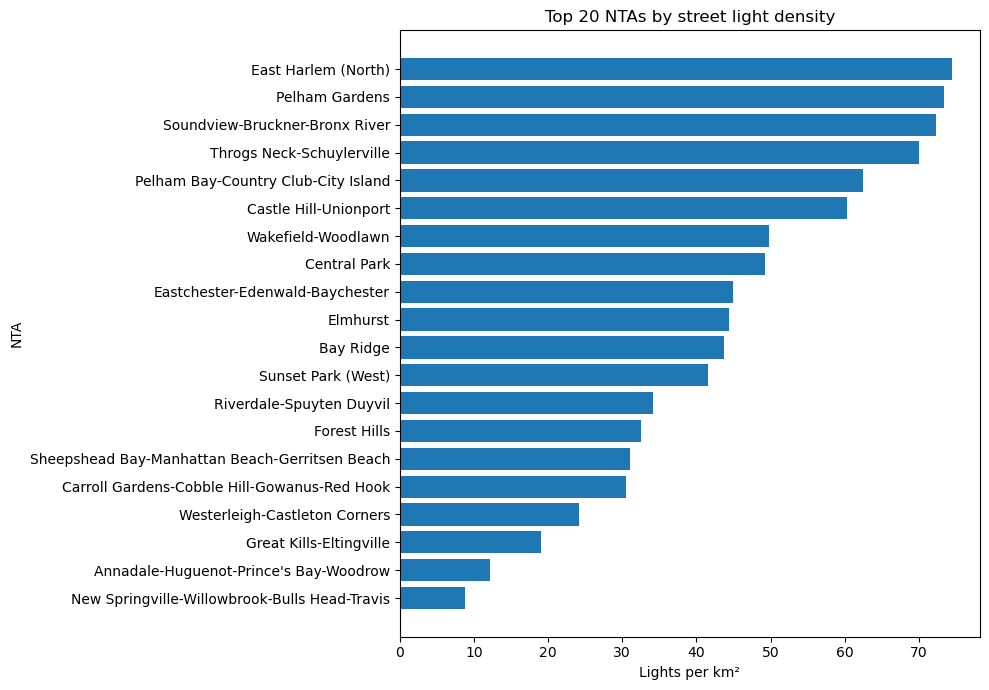

In [9]:
import matplotlib.pyplot as plt

top = result.head(20).sort_values("lights_per_km2", ascending=True)

plt.figure(figsize=(10, 7))
plt.barh(top["ntaname"], top["lights_per_km2"])
plt.xlabel("Lights per km²")
plt.ylabel("NTA")
plt.title("Top 20 NTAs by street light density")
plt.tight_layout()
plt.show()

In [ ]:


# גבולות שכונות NTA 2020 (GeoJSON דרך NYC Open Data)
nta_geojson_url = "https://data.cityofnewyork.us/resource/9nt8-h7nd.geojson?$limit=50000"


lat_candidates = ["Latitude", "latitude", "LATITUDE", "lat", "Lat"]
lon_candidates = ["Longitude", "longitude", "LONGITUDE", "lon", "Lon", "LON"]

lat_col = next((c for c in lat_candidates if c in lights.columns), None)
lon_col = next((c for c in lon_candidates if c in lights.columns), None)

if lat_col is None or lon_col is None:
    raise ValueError(f"לא נמצאו עמודות Latitude או Longitude. עמודות קיימות: {list(lights.columns)}")

lights[lat_col] = pd.to_numeric(lights[lat_col], errors="coerce")
lights[lon_col] = pd.to_numeric(lights[lon_col], errors="coerce")
lights = lights.dropna(subset=[lat_col, lon_col]).copy()

lights_gdf = gpd.GeoDataFrame(
    lights,
    geometry=gpd.points_from_xy(lights[lon_col], lights[lat_col]),
    crs="EPSG:4326",
)

# 2) טען שכונות NTA
nta = gpd.read_file(nta_geojson_url).to_crs("EPSG:4326")

# בדאטהסט הזה בדרך כלל קיימת העמודה ntaname
if "ntaname" not in nta.columns:
    raise ValueError(f"לא נמצאה עמודה ntaname. עמודות NTA: {list(nta.columns)}")

# 3) Spatial Join, שייך כל עמוד תאורה לשכונה
joined = gpd.sjoin(
    lights_gdf[["geometry"]],
    nta[["ntaname", "geometry"]],
    how="left",
    predicate="within",
)

# 4) ספירה לפי שכונה
counts = (
    joined.dropna(subset=["ntaname"])
    .groupby("ntaname")
    .size()
    .reset_index(name="street_light_count")
)

# 5) נרמול לפי שטח שכונה כדי לקבל צפיפות עמודים לקמ"ר
nta_proj = nta[["ntaname", "geometry"]].to_crs("EPSG:2263")  # מטרים, טוב לחישובי שטח בניו יורק
nta_proj["area_km2"] = nta_proj.geometry.area / 1_000_000

nta_stats = nta_proj.merge(counts, on="ntaname", how="left")
nta_stats["street_light_count"] = nta_stats["street_light_count"].fillna(0).astype(int)
nta_stats["lights_per_km2"] = nta_stats["street_light_count"] / nta_stats["area_km2"]

# חזרה ל CRS גיאוגרפי עבור Folium
nta_stats = nta_stats.to_crs("EPSG:4326")

# 6) יצירת מפה
m = folium.Map(location=[40.7128, -74.0060], zoom_start=11, tiles="CartoDB positron")

# Choropleth לפי צפיפות תאורה
folium.Choropleth(
    geo_data=nta_stats,
    name="צפיפות תאורה (עמודים לקמ״ר)",
    data=nta_stats,
    columns=["ntaname", "lights_per_km2"],
    key_on="feature.properties.ntaname",
    fill_color="YlGnBu",
    fill_opacity=0.75,
    line_opacity=0.25,
    legend_name="עמודי תאורה לקמ״ר",
).add_to(m)

# Tooltip עם פרטים
tooltip = folium.GeoJsonTooltip(
    fields=["ntaname", "street_light_count", "area_km2", "lights_per_km2"],
    aliases=["שכונה (NTA)", "מספר עמודי תאורה", "שטח בקמ״ר", "עמודים לקמ״ר"],
    localize=True,
    sticky=True
)

folium.GeoJson(
    nta_stats,
    name="פרטים",
    tooltip=tooltip,
    style_function=lambda x: {"fillOpacity": 0, "color": "black", "weight": 0.2},
).add_to(m)

folium.LayerControl(collapsed=False).add_to(m)

out_file = "nyc_street_lights_density_by_nta.html"
m.save(out_file)
print(f"נשמר קובץ מפה: {out_file}")


נשמר קובץ מפה: nyc_street_lights_density_by_nta.html


: 